### A Script for converting the generated .tiff data to zarr

In [17]:
import os
import matplotlib.pyplot as plt
import xarray as xr
import warnings
import numpy as np
import scipy
import rasterio
from rasterio.merge import merge
from rasterio.features import geometry_mask
import geopandas as gpd
from datetime import datetime

list_of_dirs = os.listdir('/work/users/jn906hluu/S2_Frankenwald_daily_HD')
list_of_dirs.sort()

date = list_of_dirs[-17]

print(f"Processing date: {date}")

rgb_path = f'/work/users/jn906hluu/S2_Frankenwald_daily_HD/{date}'
cm_path = f'/work/users/jn906hluu/S2_Frankenwald_daily_HD_CM/{date}'

crs_path = '/work/users/jn906hluu/S2_Frankenwald_daily/2019_03_17/response.tiff'
shape_file_path = '/work/users/jn906hluu/RSP/ForestCoverPatternStudy/Layers/D48/D48.shp'
example_path = '/work/users/jn906hluu/example.tif'

output_path = '/work/users/jn906hluu/S2_Frankenwald_zarr/'


Processing date: 2022-08-28


### Merging:

Luckily for us, the merging is straight forward. Create a list of rasterio images that are inside the folder (the 60 HD images that form the mosaic) and use the `rasterio.merge` function to merge them. `rasterio` already know their coordinatesystem and their boundaries and merges them to big numpy array. 

In [18]:
dataarrays_rgb = [rasterio.open(f'{os.path.join(folder)}/response.tiff') for folder in os.scandir(rgb_path) if os.path.isdir(folder)]
dataarrays_cm = [rasterio.open(f'{os.path.join(folder)}/response.tiff') for folder in os.scandir(cm_path) if os.path.isdir(folder)]

print("Merging RGB data arrays...")

merged_rgb = merge(dataarrays_rgb)

print("Merging CM data arrays...")

merged_cm = merge(dataarrays_cm)


Merging RGB data arrays...
Merging CM data arrays...


### Create the xarray Dataset

Okay, so this is really easy if you do it how I did. Just use the extent as bounds and make a linear list of coordinates. The problem: this is not true. The earth has curveature and therefore coordinates are not linear. Still the errors through that effect are quite small (and don't play a too big role right now). But if we want to match them with climate data, this topic should be reinvestigated. 

In [19]:
len_band, len_lat, len_lon, = merged_rgb[0].shape
_, len_lat_cm, len_lon_cm, = merged_cm[0].shape

bbox = [10.294189,50.307024,11.961365,50.972242]

xrds_rgb = xr.Dataset(
    data_vars = dict(
        refl = (['band','lat', 'lon'], merged_rgb[0])
    ),
    coords = dict(
        lat = np.linspace(bbox[3], bbox[1], len_lat),
        lon = np.linspace(bbox[0], bbox[2], len_lon),
        band = np.arange(1, len_band + 1),
    ),
)

xrds_mask = xr.Dataset(
    data_vars = dict(
        mask = (['lat', 'lon'], merged_cm[0][0 , : ,:] / 255)
    ),
    coords = dict(
        lat = np.linspace(bbox[3], bbox[1], len_lat_cm),
        lon = np.linspace(bbox[0], bbox[2], len_lon_cm),
    ),
)

In [20]:
print(xrds_rgb)

<xarray.Dataset>
Dimensions:  (band: 13, lat: 7638, lon: 11410)
Coordinates:
  * lat      (lat) float64 50.97 50.97 50.97 50.97 ... 50.31 50.31 50.31 50.31
  * lon      (lon) float64 10.29 10.29 10.29 10.29 ... 11.96 11.96 11.96 11.96
  * band     (band) int64 1 2 3 4 5 6 7 8 9 10 11 12 13
Data variables:
    refl     (band, lat, lon) int16 2228 2083 2083 2083 2083 ... 927 927 963 963


A small exaple of the generated dataset:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


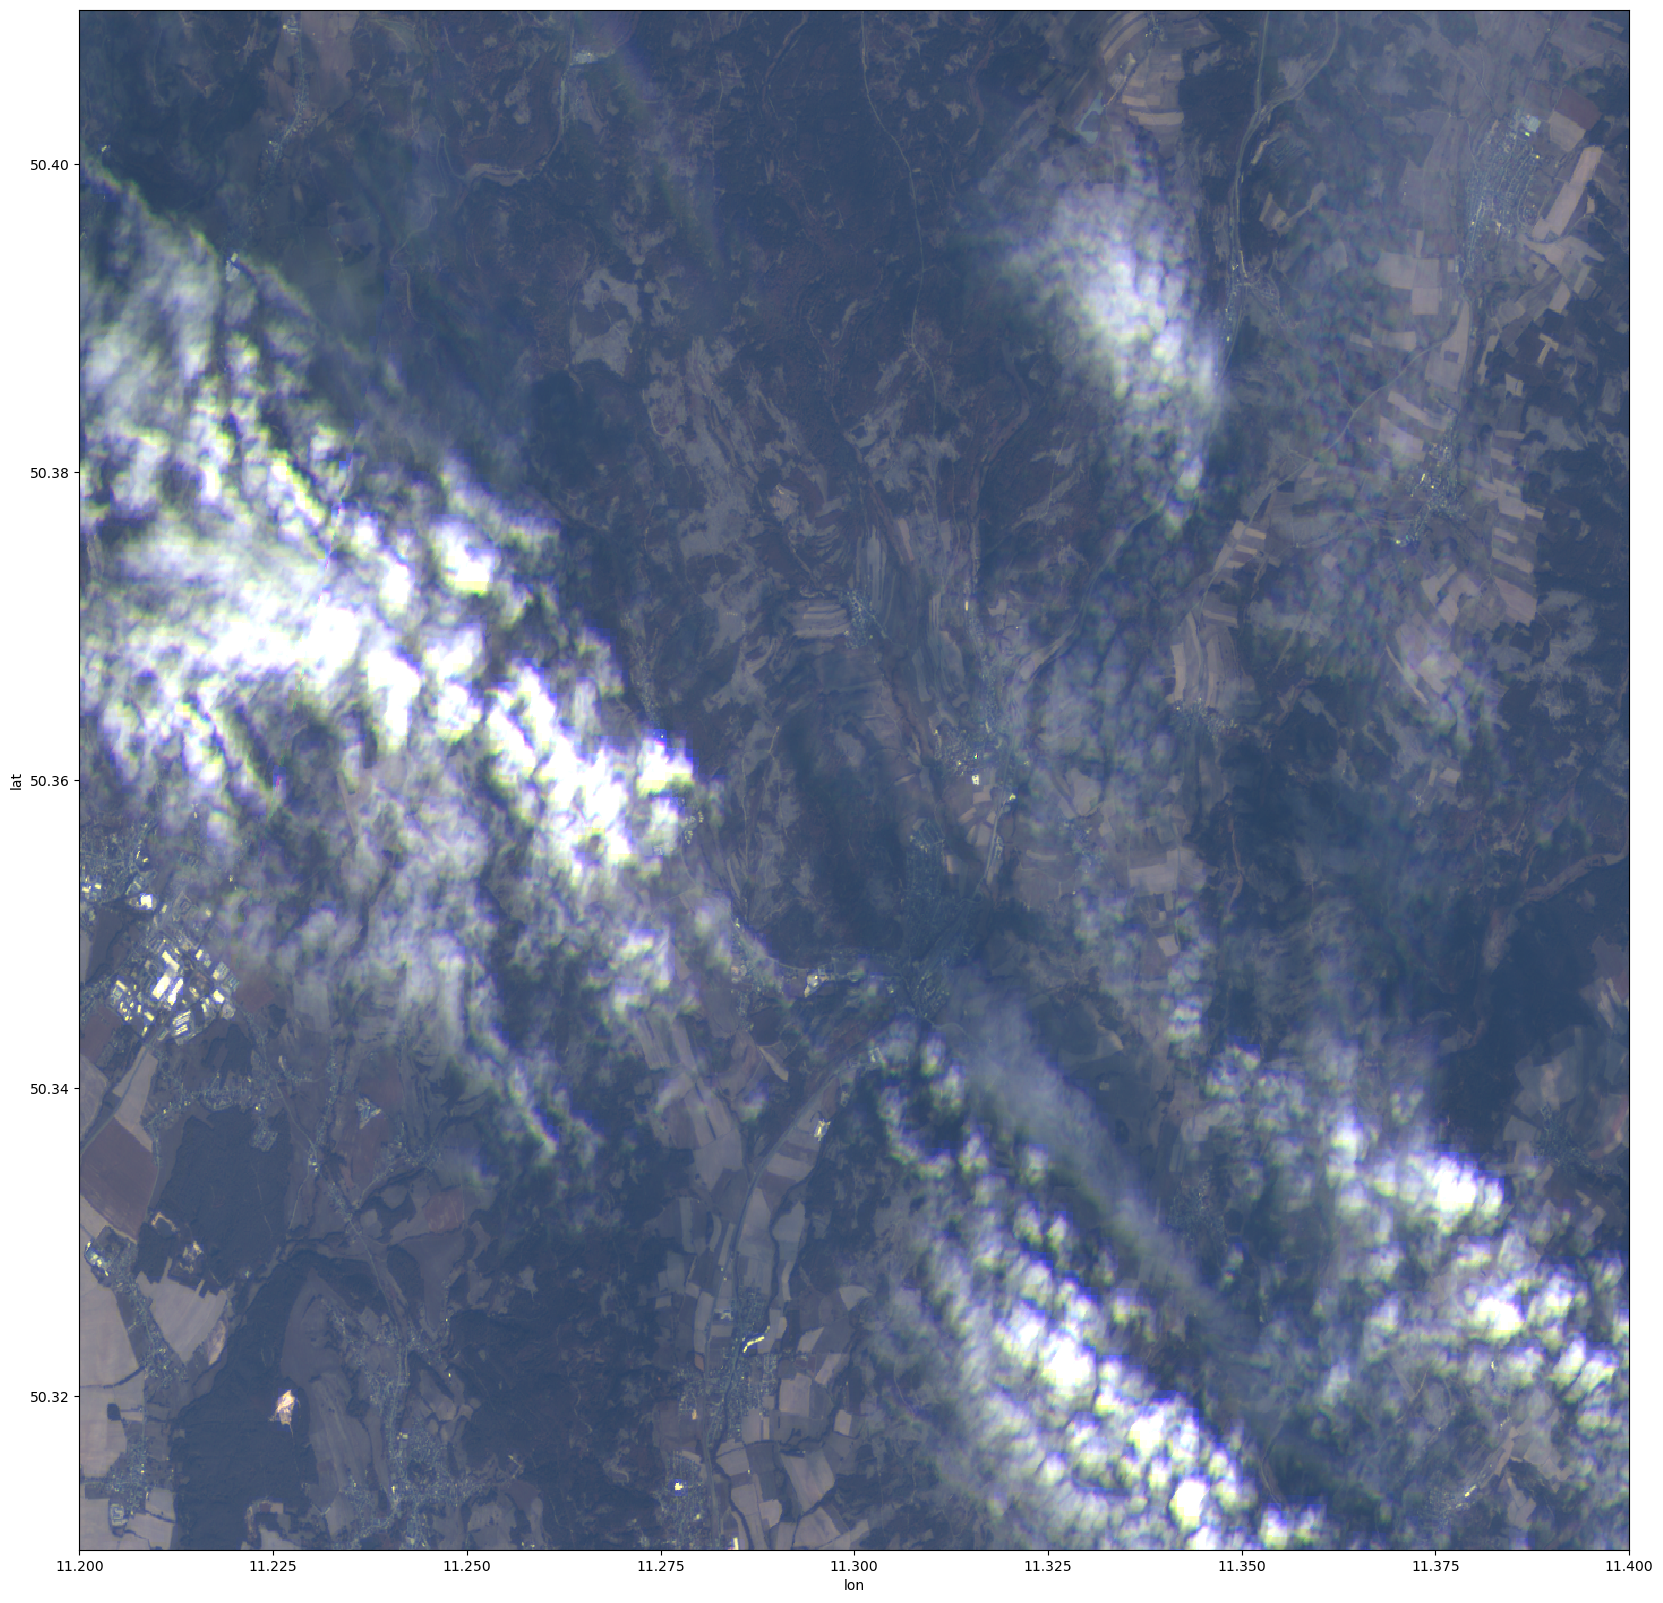

In [21]:
fig, axs = plt.subplots(figsize=(20,20))

(xrds_rgb.sel(band=[3,2,1]).sel(lon=slice(11.2, 11.4), lat=slice(50.41, 50.31)).refl / 1e4 * 3.5).plot.imshow(ax=axs)


The problem: The mask and the dataset are not necessarily of the same shape. But this can be solved by `xrds_rgb.interp()`, which let's us interpolate the dataset to a new set of coordinates. We'll do that by default for both sets to also ensure interoperability with the other dates. This makes sure we can make a big `.zarr` file at the end. 

In [22]:
new_lat = np.linspace(bbox[3], bbox[1], 7530)
new_lon = np.linspace(bbox[0], bbox[2], 11540)

xrds_rgb = xrds_rgb.interp(lat=new_lat, lon=new_lon)

xrds_rgb['mask'] = xrds_mask.interp(lat=new_lat, lon=new_lon).mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


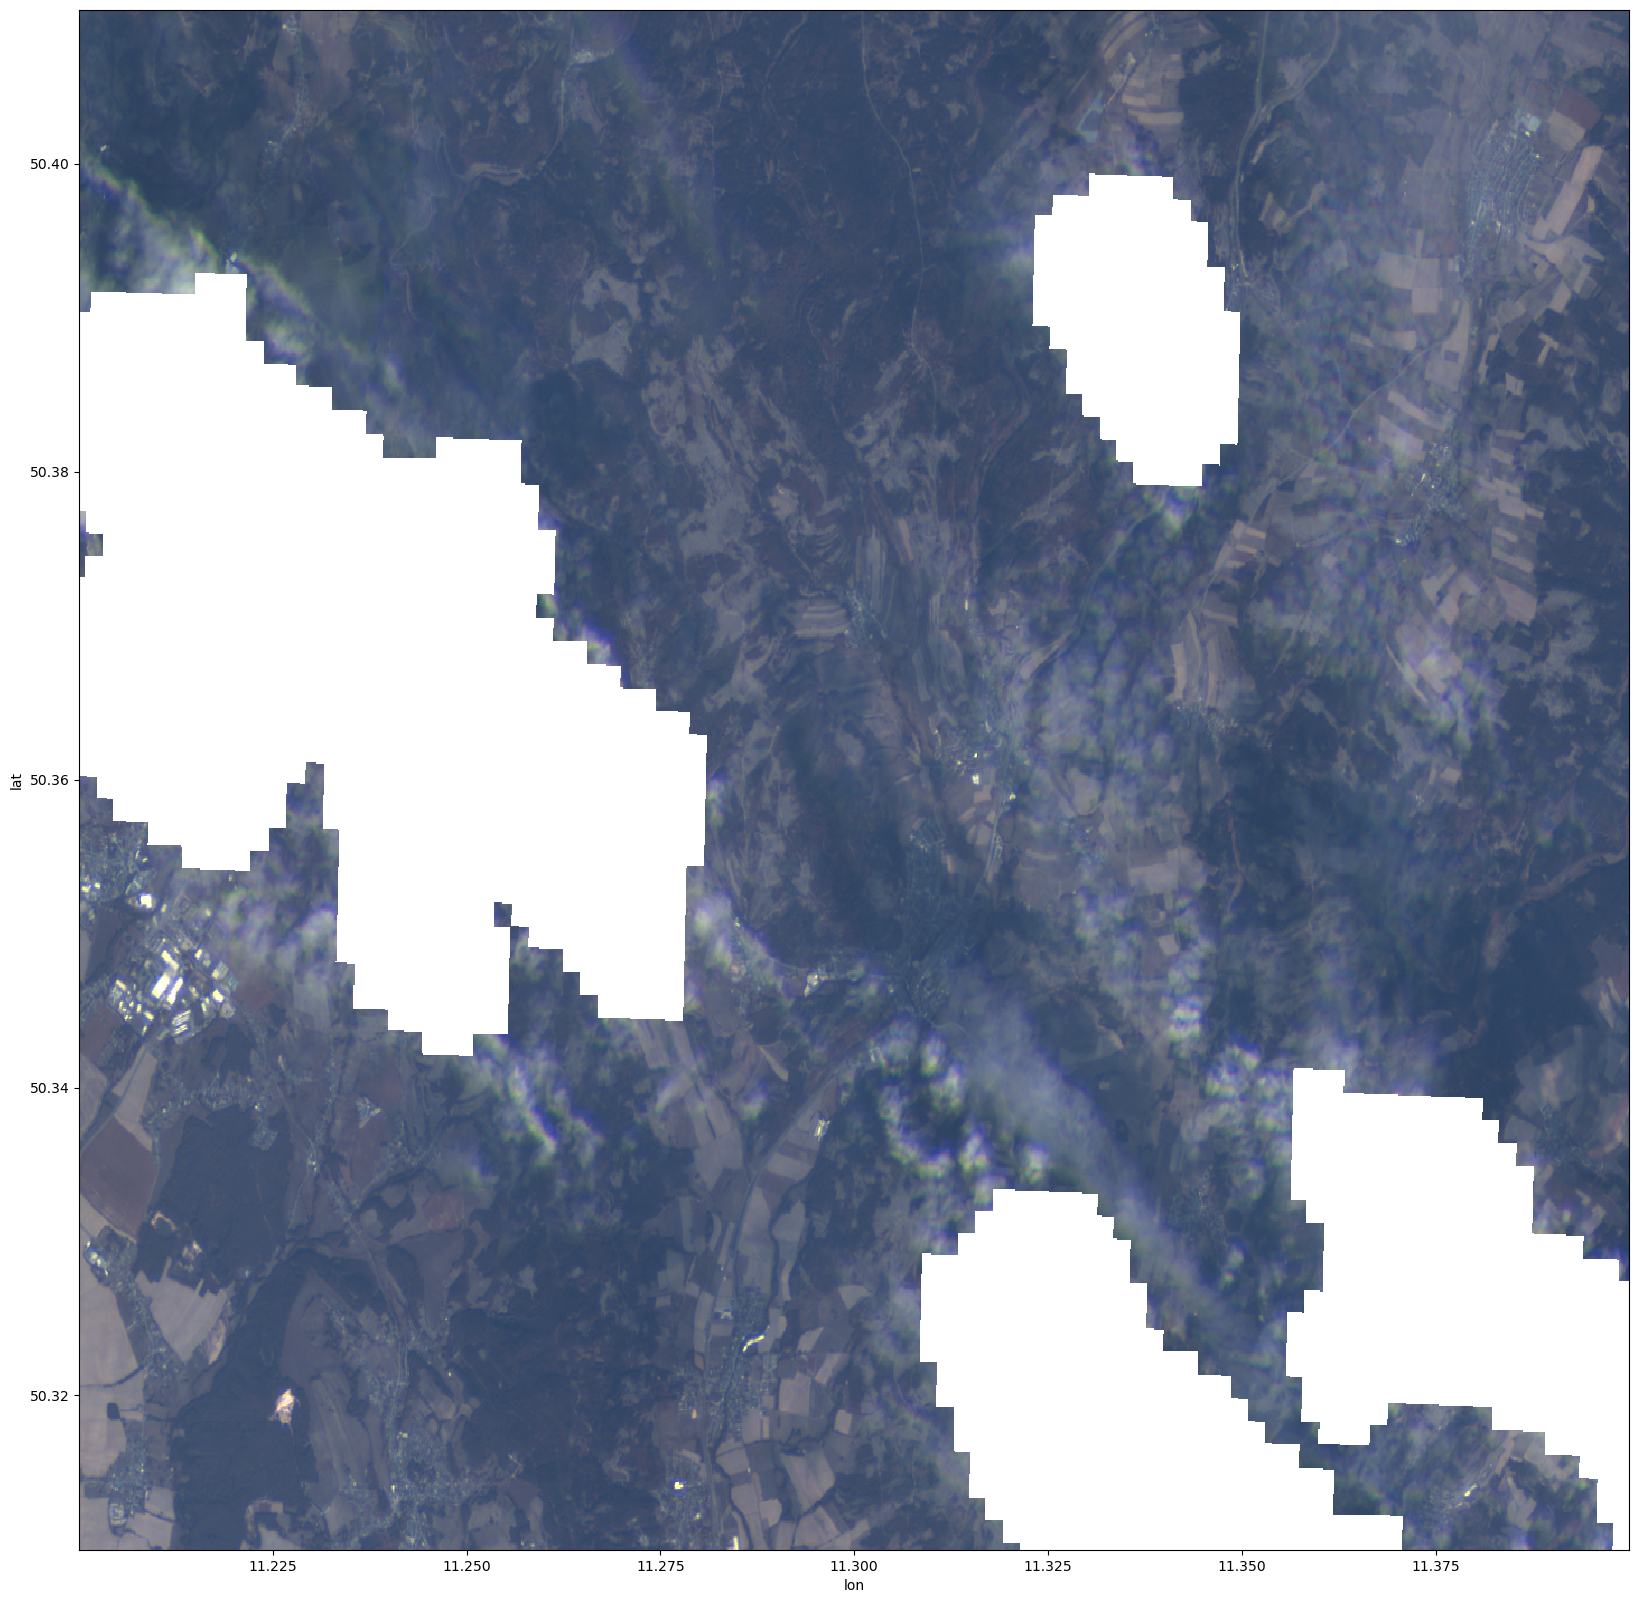

In [23]:
fig, axs = plt.subplots(figsize=(20,20))

xrds_slice = xrds_rgb.sel(band=[3,2,1]).sel(lon=slice(11.2, 11.4), lat=slice(50.41, 50.31))

(xrds_slice.refl.where(xrds_slice.mask < 1) / 1e4 * 3.5).plot.imshow(ax=axs)


How nice, the nasty clouds have dissapeared. I think this could all be way easier if would know how to use the sentinelhub API correctly, but still this is an good exercise in pre-/postprocessing. 

### Implementing the regionmask

Finally the regionmask comes into play that selects the region corresponding to the turinga / franconia forests. This is a bit messy but it has a (stupid) reason: I created a `example.tif` that has the same shape as our images but no coordinatesystem (crs), therefore we need to load another `response.tiff` with the correct crs. Though I think this could be way simplified, it worked and the mask has been generated.

In [26]:
shape_file_path = '/work/users/jn906hluu/RSP/ForestCoverPatternStudy/Layers/D48/D48.shp'

import rasterio
import geopandas as gpd
from rasterio.features import geometry_mask

shapefile = gpd.read_file(shape_file_path)


image_path = '/work/users/jn906hluu/S2_Frankenwald_daily/2019_03_17/response.tiff'
crs_path = '/work/users/jn906hluu/example.tif'

# Open the raster file
with rasterio.open(image_path) as src2:
    with rasterio.open(crs_path) as src:

        # Get the CRS of the raster file
        raster_crs = src2.crs
        # Get the shape of the raster file
        raster_shape = xrds_rgb.mask.shape

        shapefile = shapefile.to_crs(raster_crs)
        # Get the transform of the raster file
        raster_transform = src.transform
        geometry = shapefile.geometry
        # Create a mask from the geometry
        mask_tw = geometry_mask([geometry[0]], raster_shape, raster_transform, invert=True)
        mask_fw = geometry_mask([geometry[1]], raster_shape, raster_transform, invert=True)
        mask_all = ~mask_fw & ~mask_tw

Combining the regionmask with the cloudmaks wit ha logical `or` which can be also called by `|` in python. 

In [29]:
boolean_cloud_mask = xrds_rgb.mask.astype('bool')
final_mask = ~(mask_all | boolean_cloud_mask)

### Plotting the masks

Here are all the different masks. First, the mask for the turinga forest is plotted, then for the franconian forest and then for the cloud mask. The last plot corresponds to the combined mask, where yellow are the parts that will be displayed at the end.  
In the future a forestmask and other landcover-masks should be appended to the xarray. As they are mostly in shapefile formate this can be done similary to above.

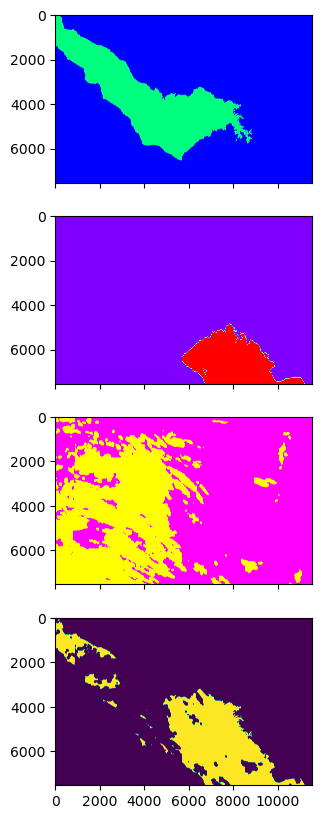

In [33]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
ax1.imshow(mask_tw, cmap ='winter')
ax2.imshow(mask_fw, cmap ='rainbow')
ax3.imshow(boolean_cloud_mask, cmap ='spring')
ax4.imshow(final_mask, cmap ='viridis')
